<h1><center>Práctica 5</center></h1>
<h2><center>Segmentación de Imagen (II) </center></h2>

El objetivo de esta práctica es familiarizar al alumno con las técnicas de extracción de características a fin de abordar un problema de segmentación utilizando aprendizaje no supervisado, en concreto el algoritmo k-medias. Para ello se trabajará con la imagen en color ‘cormoran.jpg’, que acompaña al material de esta práctica.  
 

In [35]:
#importamos librerías necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

I. Análisis visual de la imagen 
 
Lea en MATLAB la imagen ‘cormoran.jpg’ proporcionada como material adjunto en la práctica y almacénela en la variable I. Examine visualmente la imagen (representada en la Figura 1) y responda a las siguientes preguntas: 
- ¿qué objetos considera claramente discriminativos en la imagen? 
- a simple vista, ¿qué características considera discriminativas? 


<IPython.core.display.Javascript object>


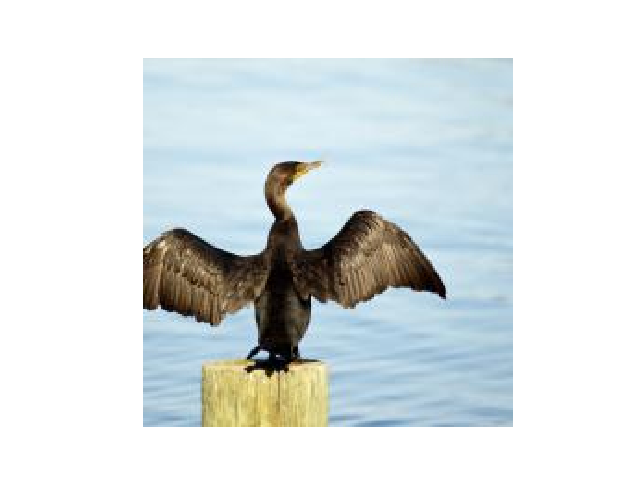

In [36]:
I = cv2.imread('cormoran_rgb.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)


%matplotlib notebook
plt.figure(1)
plt.imshow(I)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

Convierta la imagen a escala de grises (variable I_gris) y analice visualmente su histograma. ¿Cree que podría realizar la segmentación mediante umbralización múltiple? Justifique su respuesta. 

<IPython.core.display.Javascript object>


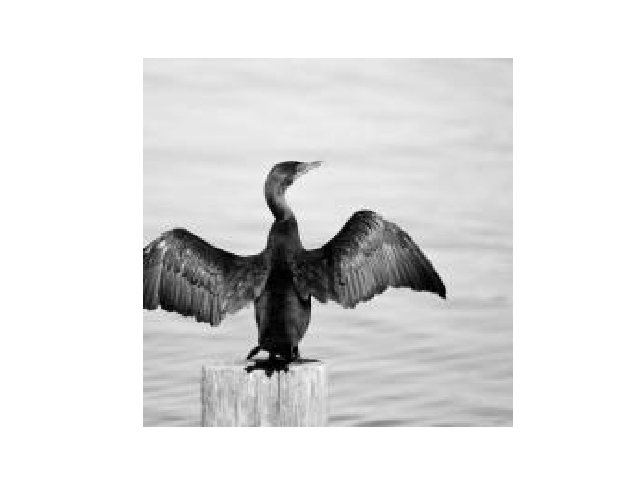

<IPython.core.display.Javascript object>


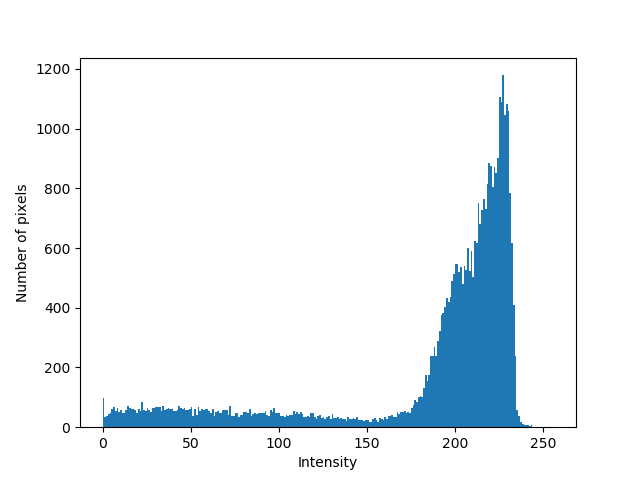

In [37]:
Igray = cv2.imread('cormoran_rgb.jpg', 0)

%matplotlib notebook
plt.figure(2)
plt.imshow(Igray, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

plt.figure('Histogram')
plt.hist(Igray.ravel(),256,[0,256]); 
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.show()

II. Características RGB y algoritmo k-medias 
 Inicialmente abordaremos el problema de segmentación considerando como características los niveles de intensidad de las componentes R, G y B de la imagen original I. Para ello: 
 - Extraiga cada componente de color de la imagen I. 

In [38]:
I_B,I_G,I_R = cv2.split(I)


- Convierta cada componente en un vector columna utilizando el comando reshape. Así, por ejemplo, para almacenar como vector columna los niveles de intensidad de los píxeles de la componente R de I, utilizaremos la siguiente secuencia de instrucciones
I_R = I(:,:,1);
[nrows, ncols] = size(I_R); 
I_R_res = reshape(I_R,nrows*ncols,1); 

In [39]:
nrows, ncols = I_B.shape

I_B_res = np.reshape(I_B, (nrows*ncols,1))
I_R_res = np.reshape(I_R, (nrows*ncols,1))
I_G_res = np.reshape(I_G, (nrows*ncols,1))
print(I_G_res.shape)


(40000, 1)


- Represente el scatter plot de los datos utilizando la función plot3(haga uso del comando help para conocer su sintaxis). ¿Observa grupos de puntos claramente diferenciados?

<IPython.core.display.Javascript object>


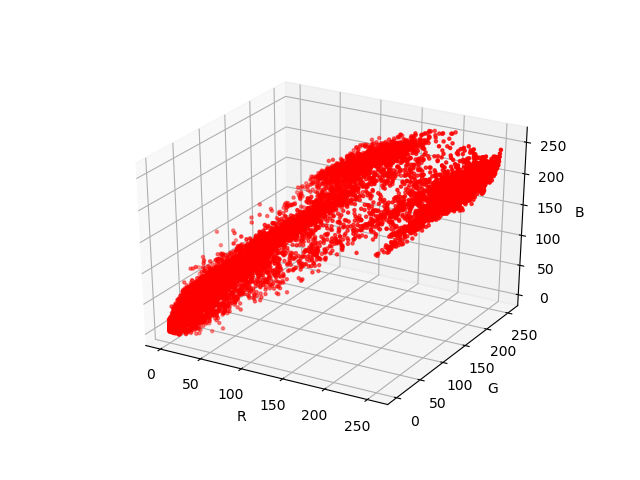

In [43]:
fig = plt.figure('scatter plot')
ax = fig.add_subplot(111, projection='3d')

ax.scatter(I_R_res, I_G_res, I_B_res, c='r', marker='.')

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

plt.show()